In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
ALPHA = 3.0

In [3]:
feerates = [1.0, 1.1, 1.2]*10 + [1.5]*3000 + [2]*3000 + [2.1]*3000 + [3, 4, 5]*10
# feerates = [1.0, 1.1, 1.2] + [1.1]*100 + [1.2]*100 + [1.3]*100  # + [3, 4, 5, 100]

In [4]:
total_weight = sum(np.array(feerates)**ALPHA)
print('Total mempool weight: ', total_weight)

Total mempool weight:  64108.589999995806


In [5]:
avg_mass = 2000
bps = 1
block_mass_limit = 500_000
network_mass_rate = bps * block_mass_limit

In [6]:
print('Inclusion interval: ', avg_mass/network_mass_rate)

Inclusion interval:  0.004


In [7]:
class FeerateBucket:
    def __init__(self, feerate, estimated_seconds):
        self.feerate = feerate
        self.estimated_seconds = estimated_seconds
        

class FeerateEstimations:
    def __init__(self, low_bucket, normal_bucket, priority_bucket):
        self.low_bucket = low_bucket        
        self.normal_bucket = normal_bucket
        self.priority_bucket = priority_bucket
    
    def __repr__(self):
        return 'Feerates:\t{}, {}, {} \nTimes:\t\t{}, {}, {}'.format(self.low_bucket.feerate, 
                                                self.normal_bucket.feerate,
                                                self.priority_bucket.feerate, 
                                                self.low_bucket.estimated_seconds, 
                                                self.normal_bucket.estimated_seconds, 
                                                self.priority_bucket.estimated_seconds)
    def feerates(self):
        return np.array([
            self.low_bucket.feerate, 
            self.normal_bucket.feerate,
            self.priority_bucket.feerate
        ])
        
    def times(self):
        return np.array([
            self.low_bucket.estimated_seconds, 
            self.normal_bucket.estimated_seconds,
            self.priority_bucket.estimated_seconds
        ])
    
class FeerateEstimator:
    """
    `total_weight`: The total probability weight of all current mempool ready 
                    transactions, i.e., Σ_{tx in mempool}(tx.fee/tx.mass)^ALPHA
                    
    'inclusion_interval': The amortized time between transactions given the current 
                    transaction masses present in the mempool, i.e., the inverse 
                    of the transaction inclusion rate. For instance, if the average 
                    transaction mass is 2500 grams, the block mass limit is 500,000
                    and the network has 10 BPS, then this number would be 1/2000 seconds.
    """
    def __init__(self, total_weight, inclusion_interval):
        self.total_weight = total_weight
        self.inclusion_interval = inclusion_interval

    """
    Feerate to time function: f(feerate) = inclusion_interval * (1/p(feerate))
    where p(feerate) = feerate^ALPHA/(total_weight + feerate^ALPHA) represents 
    the probability function for drawing `feerate` from the mempool
    in a single trial. The inverse 1/p is the expected number of trials until
    success (with repetition), thus multiplied by inclusion_interval it provides an
    approximation to the overall expected waiting time
    """
    def feerate_to_time(self, feerate):
        c1, c2 = self.inclusion_interval, self.total_weight
        return c1 * c2 / feerate**ALPHA + c1

    """
    The inverse function of `feerate_to_time`
    """
    def time_to_feerate(self, time):
        c1, c2 = self.inclusion_interval, self.total_weight
        return ((c1 * c2 / time) / (1 - c1 / time))**(1 / ALPHA)
    
    """
    The antiderivative function of 
    feerate_to_time excluding the constant shift `+ c1`
    """
    def feerate_to_time_antiderivative(self, feerate):
        c1, c2 = self.inclusion_interval, self.total_weight
        return c1 * c2 / (-2.0 * feerate**(ALPHA - 1))
    
    """
    Returns the feerate value for which the integral area is `frac` of the total area.
    See figures below for illustration
    """
    def quantile(self, lower, upper, frac):
        c1, c2 = self.inclusion_interval, self.total_weight
        z1 = self.feerate_to_time_antiderivative(lower)
        z2 = self.feerate_to_time_antiderivative(upper)
        z = frac * z2 + (1.0 - frac) * z1
        return ((c1 * c2) / (-2 * z))**(1.0 / (ALPHA - 1.0))
    
    def calc_estimations(self):
        # Choose `high` such that it provides sub-second waiting time
        high = self.time_to_feerate(1.0)
        # Choose `low` feerate such that it provides sub-hour waiting time AND it covers (at least) the 0.25 quantile
        low = max(self.time_to_feerate(3600.0), self.quantile(1.0, high, 0.25))
        # Choose `mid` feerate such that it provides sub-minute waiting time AND it covers (at least) the 0.5 quantile
        mid = max(self.time_to_feerate(60.0), self.quantile(1.0, high, 0.5))
        # low = self.quantile(1.0, high, 0.25)
        # mid = self.quantile(1.0, high, 0.5)
        return FeerateEstimations(
            FeerateBucket(low, self.feerate_to_time(low)),
            FeerateBucket(mid, self.feerate_to_time(mid)),
            FeerateBucket(high, self.feerate_to_time(high)))

### Feerate estimation

The figure below illustrates the estimator selectoin. We first estimate the `feerate_to_time` function and then select 3 meaningfull points by analyzing the curve and its integral (see `calc_estimations`). 

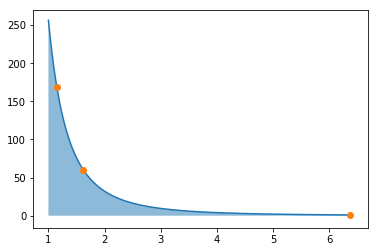

Feerates:	1.1499744606513134, 1.6228733928138133, 6.361686926992798 
Times:		168.62498827393395, 59.999999999999986, 1.0000000000000004

In [8]:
estimator = FeerateEstimator(total_weight=total_weight, 
                             inclusion_interval=avg_mass/network_mass_rate)

pred = estimator.calc_estimations()
x = np.linspace(1, pred.priority_bucket.feerate, 100000)
y = estimator.feerate_to_time(x)
plt.figure()
plt.plot(x, y)
plt.fill_between(x, estimator.inclusion_interval, y2=y, alpha=0.5)
plt.scatter(pred.feerates(), pred.times(), zorder=100)
plt.show()
pred

### Interpolating the original function using two of the points

The code below reverse engineers the original curve using only 2 of the estimated points

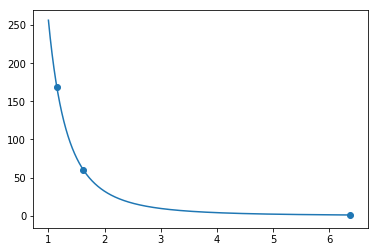

(array([168.62498827,  59.99018107,   0.98484788]),
 array([168.62498827,  60.        ,   1.        ]))

In [9]:
x1, x2 = pred.low_bucket.feerate**ALPHA, pred.normal_bucket.feerate**ALPHA
y1, y2 = pred.low_bucket.estimated_seconds, pred.normal_bucket.estimated_seconds
b2 = (y1 - y2*x2/x1) / (1 - x1/x2)
b1 = (y1 - b2) * x1
def p(ff):
    return b1/ff**ALPHA + b2

plt.figure()
plt.plot(x, p(x))
plt.scatter(pred.feerates(), pred.times(), zorder=100)
plt.show()
p(pred.feerates()), pred.times()

### Challenge: outliers

The segment below illustrates a challenge in the current approach. It is sufficient to add a single outlier 
to the total weight (with `feerate=100`), and the `feerate_to_time` function is notably influenced. In truth, this tx should not affect our prediction because it only captures the first slot of each block, however because we sample with repetition it has a significant impact on the function. The following figure shows the `feerate_to_time` function with such an outlier 

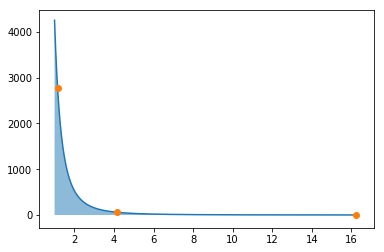

Feerates:	1.1539704395225572, 4.139754128892224, 16.2278954349457 
Times:		2769.889957638353, 60.00000000000002, 1.0000000000000007

In [10]:
estimator = FeerateEstimator(total_weight=total_weight + 100**ALPHA, 
                             inclusion_interval=avg_mass/network_mass_rate)

pred = estimator.calc_estimations()
x = np.linspace(1, pred.priority_bucket.feerate, 100000)
y = estimator.feerate_to_time(x)
plt.figure()
plt.plot(x, y)
plt.fill_between(x, estimator.inclusion_interval, y2=y, alpha=0.5)
plt.scatter(pred.feerates(), pred.times(), zorder=100)
plt.show()
pred

### Outliers: solution

Compute the estimator conditioned on the event the the top most transaction captures the first slot. This decreases `total_weight` on the one hand (thus increasing `p`), while increasing `inclusion_interval` on the other, by capturing a block slot. If this estimator gives lower prediction times we switch to it, and then repeat the process with the next highest transaction. The process convegres when the estimator is no longer improving or if all block slots are captured. 

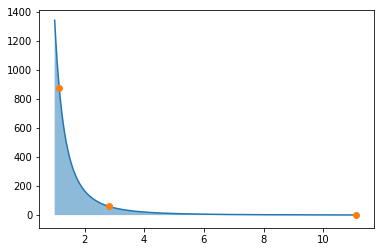

Feerates:	1.1531420689155165, 2.816548045571761, 11.10120050773006 
Times:		874.010579873836, 60.00000000000001, 1.0000000000000004

In [11]:
def build_estimator():
    _feerates = [1.0]*10 + [1.1]*10 + [1.2]*10 + [1.5]*3000 + [2]*3000\
+ [2.1]*3000 + [3]*10 + [4]*10 + [5]*10 + [6] + [7] + [10] + [100] + [200]*200
    _total_weight = sum(np.array(_feerates)**ALPHA)
    _network_mass_rate = bps * block_mass_limit
    estimator = FeerateEstimator(total_weight=_total_weight, 
                                 inclusion_interval=avg_mass/_network_mass_rate)
    
    nr = _network_mass_rate
    for i in range(len(_feerates)-1, -1, -1):
        tw = sum(np.array(_feerates[:i])**ALPHA)
        nr -= avg_mass
        if nr <= 0:
            print("net mass rate {}", nr)
            break
        e = FeerateEstimator(total_weight=tw, 
                             inclusion_interval=avg_mass/nr)
        if e.feerate_to_time(1.0) < estimator.feerate_to_time(1.0):
            # print("removing {}".format(_feerates[i]))
            estimator = e
        else:
            break
        
    return estimator

estimator = build_estimator()
pred = estimator.calc_estimations()
x = np.linspace(1, pred.priority_bucket.feerate, 100000)
y = estimator.feerate_to_time(x)
plt.figure()
plt.plot(x, y)
plt.fill_between(x, estimator.inclusion_interval, y2=y, alpha=0.5)
plt.scatter(pred.feerates(), pred.times(), zorder=100)
plt.show()
pred